In [1]:
from pathlib import Path
import os

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from src.model_genesis.tf_data_hdf5 import get_tf_data
from src.model_genesis.utils import get_tf_degrade_image, degrade_image
from src.models.models_3d import Unet


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
h5_file = h5py.File("../data/processed/hdf5_2d_pet_standardized_lung_slices/data.hdf5", "r")

In [3]:
clinical_df = pd.read_csv(
    "../data/clinical_info_with_lung_info.csv").set_index("patient_id")


In [11]:
tf_degrade_image = get_tf_degrade_image()

In [12]:
ds = get_tf_data(h5_file, clinical_df, output_image_shape=(128,128,128))
ds = ds.map(lambda x,p: (x, tf_degrade_image(x), p))

In [16]:
for image, image_degraded, patient in ds.take(1):
    pass

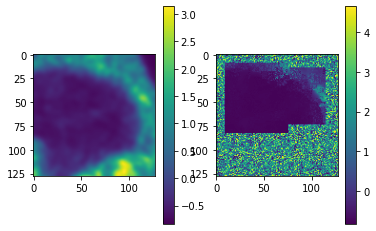

In [17]:
plt.subplot(121)
plt.imshow(image[:,:,32,1])
plt.colorbar()
plt.subplot(122)
plt.imshow(image_degraded[:,:,32,1])
plt.colorbar()

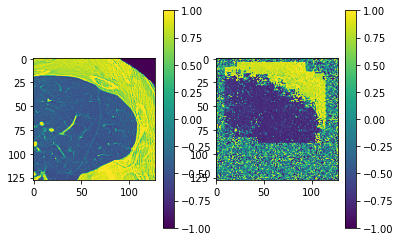

In [18]:
n_slice = 64

plt.subplot(121)
plt.imshow(image[:,:,n_slice,0])
plt.colorbar()
plt.subplot(122)
plt.imshow(image_degraded[:,:,n_slice,0])
plt.colorbar()

In [ ]:
model = Unet(output_channels=2, last_activation="linear")
model_pretrained = tf.keras.models.load_model(
    "/home/valentin/python_wkspce/plc_segmentation/models/unet_genesis__20220106-151319/model_weight"
)


In [ ]:
model(image.numpy()[np.newaxis,...])

In [ ]:
model.set_weights(model_pretrained.get_weights())

In [ ]:
yo = model(image.numpy()[np.newaxis, :64,:64,:64,:])

In [ ]:
model.summary()

In [ ]:
model.down_stack[1].layers[1].input

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, down_stack):
        super().__init__()
        self.down_stack = down_stack

    def call(self, x, training=None):
        for block in self.down_stack:
            x = block(x, training=training)

        return x

In [ ]:
def get_encoder(model_unet):
    input_model = model_unet.down_stack[0].input
    n_channels = input_model.shape[-1]
    inp = tf.keras.Input(shape=(128, 128, 128, n_channels))
    x = inp
    for block in model_unet.down_stack:
        x = block(x)

    return tf.keras.Model(inputs=inp, outputs=x)


In [ ]:
encoder = get_encoder(model_pretrained)
# encoder = Encoder(model.down_stack)

In [ ]:
encoder.summary()

In [ ]:
image.shape

In [ ]:
yo = encoder(image.numpy()[np.newaxis,:128,:128,:128,:])

In [ ]:
yo.shape